In [11]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

In [12]:
pima = pd.read_csv('Data/diabetes.csv', sep=';')
df = pd.read_csv('Data/diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('Data/diabetes_pt2.csv', sep=';')

In [13]:
feature_columns = ['Glucose', 'Age', 'BMI', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction']

stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}

test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [14]:
sm2 = CmdStanModel(stan_file='Stan/code_2.stan')

fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=1000, seed=2108005)
df3 = fit2.draws_pd()
df3.head()

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_glucose,beta_age,...,log_lik[284],log_lik[285],log_lik[286],log_lik[287],log_lik[288],log_lik[289],log_lik[290],log_lik[291],log_lik[292],log_lik[293]
0,-197.616,0.998455,0.075479,6.0,63.0,0.0,199.580,-5.92478,0.019515,0.020464,...,-0.335699,-0.733835,-0.157622,-0.123893,-0.201630,-0.264216,-0.258792,-0.183110,-0.166059,-0.153539
1,-197.161,0.927845,0.075479,5.0,63.0,0.0,201.182,-5.87235,0.029941,0.046541,...,-0.419829,-1.401820,-0.117973,-0.132267,-0.196944,-0.290043,-0.140312,-0.175130,-0.231115,-0.153723
2,-197.283,0.959426,0.075479,4.0,31.0,0.0,201.030,-6.13605,0.027829,0.041593,...,-0.387422,-1.246620,-0.113924,-0.119334,-0.180047,-0.278091,-0.176655,-0.164407,-0.196244,-0.131131
3,-197.330,0.997647,0.075479,5.0,63.0,0.0,199.791,-4.75414,0.023610,0.062245,...,-0.379161,-1.312630,-0.131529,-0.134804,-0.198658,-0.398481,-0.245785,-0.150960,-0.278445,-0.182039
4,-198.785,0.910336,0.075479,6.0,63.0,0.0,203.309,-6.20162,0.032957,0.019600,...,-0.429403,-1.093260,-0.133231,-0.133729,-0.202483,-0.231691,-0.080133,-0.189954,-0.196449,-0.188764


In [15]:
alpha_mean = df3['alpha'].mean()
beta_glucose_mean = df3['beta_glucose'].mean()
beta_age_mean = df3['beta_age'].mean()
beta_bmi_mean = df3['beta_bmi'].mean()
beta_bp_mean = df3['beta_bp'].mean()
beta_insulin_mean = df3['beta_insulin'].mean()
beta_dpf_mean = df3['beta_dpf'].mean()

In [16]:
logit_preds_test = alpha_mean + (test2_data['X'][:, 0] * beta_glucose_mean +
                                 test2_data['X'][:, 1] * beta_age_mean +
                                 test2_data['X'][:, 2] * beta_bmi_mean +
                                 test2_data['X'][:, 3] * beta_bp_mean + 
                                 test2_data['X'][:, 4] * beta_insulin_mean +
                                 test2_data['X'][:, 5] * beta_dpf_mean)

probs_test2 = 1 / (1 + np.exp(-logit_preds_test))

probs_df = pd.DataFrame(probs_test2, columns=['Probability'])
print(probs_df.head())

   Probability
0     0.171685
1     0.265957
2     0.523345
3     0.331152
4     0.206111


In [17]:
preds_test2 = (probs_test2 > 0.5).astype(int)

accuracy = accuracy_score(test2_data['y'], preds_test2)
precision = precision_score(test2_data['y'], preds_test2)
recall = recall_score(test2_data['y'], preds_test2)
f1 = f1_score(test2_data['y'], preds_test2)

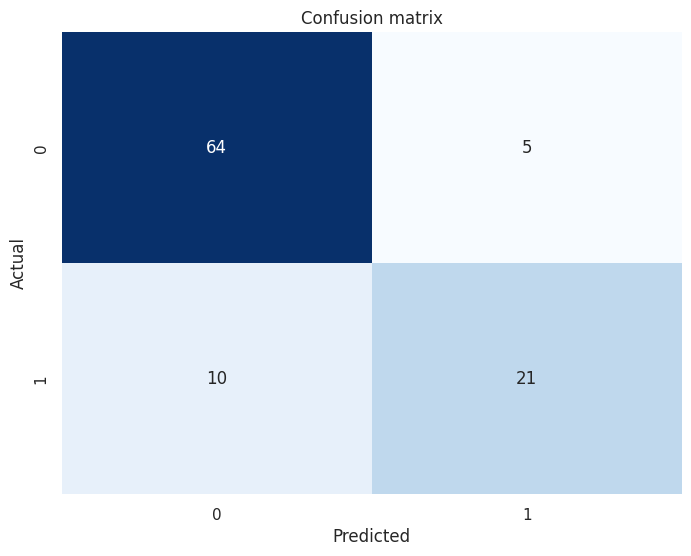

In [18]:

preds_test2 = (probs_test2 > 0.5).astype(int)

conf_matrix = confusion_matrix(test2_data['y'], preds_test2)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
fpr, tpr, _ = roc_curve(test2_data['y'], probs_test2)
roc_auc = auc(fpr, tpr)
 
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.85
Precision: 0.81
Recall: 0.68
F1 Score: 0.74


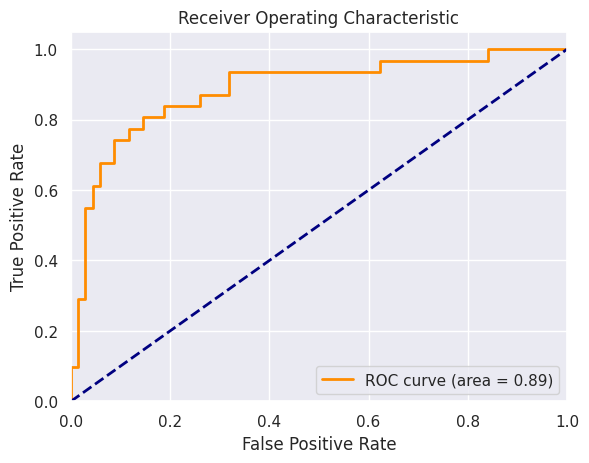

In [20]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()